# STAC Catalogs on SURF dCache Storage

## Sentinel-2 image downloading

We search for some assets in the [Sentinel-2 Open Data collection available on AWS](https://registry.opendata.aws/sentinel-2-l2a-cogs/). We query the [Earth Search STAC API end point](https://earth-search.aws.element84.com/v0) using [PySTAC Client](https://pystac-client.readthedocs.io). In order to install this tool, uncomment and run the following cell:

In [1]:
# !pip install pystac-client

In [2]:
from pystac_client import Client

In [3]:
STAC_API_URL = "https://earth-search.aws.element84.com/v0"

client = Client.open(STAC_API_URL)

# search assets
search = client.search(    
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2018-03-16/2018-03-25",
    # query Sentinel-2 tile 5VNK
    query=[
        "sentinel:utm_zone=5",
        "sentinel:latitude_band=V",
        "sentinel:grid_square=NK"
    ]
)

In [4]:
# get all items matching the query
items = search.get_all_items()

We create a STAC catalog to save these entries using [PySTAC](https://pystac.readthedocs.io).

In [5]:
from pystac import Catalog, Item

In [6]:
# create new catalog
catalog = Catalog(
    id='s2-catalog',
    description='Test catalog for Sentinel-2 data'
)
catalog

<Catalog id=s2-catalog>

In [7]:
# add search results to catalog
catalog.add_items(items)
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


Let's save the catalog on the dCache storage. For authentication we use a macaroon (see [here](https://github.com/sara-nl/GridScripts/blob/master/get-macaroon) for instructions on how to generate the token), but username/password authentication can aso be employed:

In [8]:
import stac2dcache

stac2dcache.configure(token_filename="macaroon.dat")

We can then read/write PySTAC objects on dCache as:

In [9]:
urlpath = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/tmp-sentinel-2-catalog"

# temporary fix to https://github.com/stac-utils/pystac/issues/666 ?
catalog._stac_io = stac2dcache.stac_io
catalog.normalize_and_save(
    urlpath,
    catalog_type='SELF_CONTAINED'
)

The catalog is now written to the storage. In order to re-load it into memory:

In [10]:
catalog_url = urlpath + '/catalog.json'

# read catalog from storage
catalog = Catalog.from_file(
    catalog_url, 
    stac_io=stac2dcache.stac_io
)

In [11]:
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


Let's now retrieve few assets from AWS, and save them to dCache. We download the original XML metadata file and one band file ('B-1') from the MSI.

In [12]:
from stac2dcache.utils import copy_asset

In [13]:
# download assets - from web to storage
for asset_key in ('metadata', 'B01'):
    copy_asset(
        catalog, 
        asset_key, 
        update_catalog=True,  # update the catalog's links to the assets  
        filesystem_to=stac2dcache.fs,
        max_workers=4
    )
    
# save catalog with the updated links
catalog.normalize_and_save(urlpath, catalog_type='SELF_CONTAINED')

Note that `copy_asset` makes use of multiple processes to download the data (use the `max_workers` argument to set the number of processes spawned).

Files have been saved on the dCache storage. Let's now download one example file from dCache to the local file system for inspection or further processing.

In [14]:
# download an asset - from storage to local filesystem
copy_asset(
    catalog, 
    'B01', 
    item_id='S2B_5VNK_20180319_0_L2A',
    to_uri='./tmp',
    filesystem_from=stac2dcache.fs
)

In [15]:
! ls ./tmp/S2B_5VNK_20180319_0_L2A/B01.tif

./tmp/S2B_5VNK_20180319_0_L2A/B01.tif


Instead of dowloading assets, STAC2dCache allows to directly open and load into memory few common file formats:

In [16]:
from stac2dcache.utils import get_asset

In [17]:
# read metadata from storage (as text file)
data = get_asset(
    catalog,
    'metadata',
    'S2B_5VNK_20180319_0_L2A',
    filesystem=stac2dcache.fs
)

# print top five lines
data.splitlines()[:5]

["<?xml version='1.0' encoding='UTF-8'?>",
 '<n1:Level-2A_Tile_ID xmlns:n1="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd /dpc/app/s2ipf/FORMAT_METADATA_TILE_L1C/02.11.01/scripts/../../../schemas/02.13.01/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd">',
 '  <n1:General_Info>',
 '    <L1C_TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L1C_TL_EPAE_20180319T231157_A005403_T05VNK_N02.06</L1C_TILE_ID>',
 '    <TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L2A_TL_SHIT_20201104T123444_A005403_T05VNK_N00.01</TILE_ID>']

In [18]:
# same for raster data (as xarray object)
data = get_asset(
    catalog,
    'B01',
    'S2B_5VNK_20180319_0_L2A',
    filesystem=stac2dcache.fs
)
data

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
array([[[    0,     0,     0, ...,  5703,  5936,  5016],
        [    0,     0,     0, ...,  6587,  6828,  5825],
        [    0,     0,     0, ...,  6699,  6655,  5496],
        ...,
        [ 9110, 10489,  9932, ...,  1733,  2269,  1933],
        [ 9406, 10773, 10684, ...,  1799,  2759,  2406],
        [ 8260,  9473,  9653, ...,  1170,  1634,  1917]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5.001e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06 6.89e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Note that by default the data in the `DataArray` is loaded into memory - set `load=False` in order to skip the loading. Mind that `load=False` leaves a temporary file with the headers on the local file system. This file contains the token to authenticate on the storage system, so it should be deleted once done with accessing the data. 

In order to plot the data, [matplotlib](https://matplotlib.org) needs to be installed (uncomment and run the following lines to do that).

In [19]:
# !pip install matplotlib

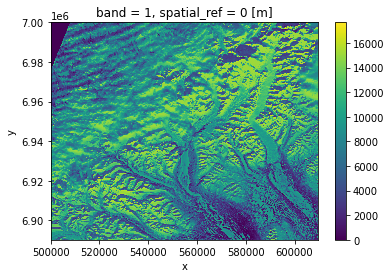

In [20]:
data.plot()

## Sentinel-1 image downloading

Below we demontrate how to search Sentinel-1 GRD data from the Alaska Satellite Facility (ASF) enpoint that is part of the [NASA Common Metadata Repository (CMR) STAC catalog](https://cmr.earthdata.nasa.gov/search). 
As for Sentinel-2, we first search the available assets with PySTAC Client:

In [21]:
STAC_API_URL = "https://cmr.earthdata.nasa.gov/stac/ASF"
bbox = [4.6, 52.3, 4.7, 52.4]  # (min lon, min lat, max lon, max lat) AMS area

client = Client.open(STAC_API_URL)

# search assets
search = client.search(    
    collections=[
        "SENTINEL-1A_DP_GRD_HIGH.v1",
        "SENTINEL-1B_DP_GRD_HIGH.v1"
    ],
    datetime="2019-01-02",
    bbox=bbox
)

In [22]:
# get all items matching the query
items = search.get_all_items()

Then we build a catalog with the found items. Note that we have limited our search to a single item due to the large size of S1 GRD data.

In [23]:
catalog = Catalog(
    id='s1-catalog',
    description='Test catalog for Sentinel-1 data'
)
catalog.add_items(items)
catalog.describe()

* <Catalog id=s1-catalog>
  * <Item id=S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6-GRD_HD>


In [24]:
urlpath = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/tmp-sentinel-1-catalog"

catalog._stac_io = stac2dcache.stac_io
catalog.normalize_and_save(
    urlpath,
    catalog_type='SELF_CONTAINED'
)

To retrieve Sentinel-1 images, we need to first get EarthData login credentials (see [this guide](https://wiki.earthdata.nasa.gov/display/EL/How+To+Register+For+an+EarthData+Login+Profile)). Also make sure you authorize all applications related to the Alaska Satellite Facility before downloading the data, see instructions [here](https://wiki.earthdata.nasa.gov/display/EL/How+To+Pre-authorize+an+application)).
After creating the loging credentials, you can fill them in the following blanks.

In [25]:
from getpass import getpass
nasa_fs = stac2dcache.configure_filesystem(
    username=getpass("username: "),
    password=getpass("password: ")
)

username:  ········
password:  ·············


We download S1 data to the local file system:

In [26]:
assets = ('browse', 'data')

for asset_key in assets:
    copy_asset(
        catalog, 
        asset_key, 
        filesystem_from=nasa_fs,
        to_uri="./tmp"
    )

In [27]:
! ls ./tmp/S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6-GRD_HD/B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6-GRD_HD

S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6.jpg
S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6.zip
